## Using ONNX Runtime for data preprocessing - ResNet 50 Inference

This example demonstrates how to use ONNX Runtime for data preprocessing. This notebook extends [an example from onnx-docker repository](https://github.com/onnx/onnx-docker/blob/master/onnx-ecosystem/inference_demos/resnet50_modelzoo_onnxruntime_inference.ipynb), which loads an image classification model from the [ONNX model zoo](https://github.com/onnx/models) and confirm its accuracy based on included test data.

The example has been extended to replace the preprocessing implementation with a second ONNX model.

In [1]:
import numpy as np    # we're going to use numpy to process input and output data
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
import onnx
from onnx import numpy_helper
import urllib.request
import json
import time

# display images in notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

In [2]:
onnx_model_url = "https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v2/resnet50v2.tar.gz"
imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# retrieve our model from the ONNX model zoo
urllib.request.urlretrieve(onnx_model_url, filename="resnet50v2.tar.gz")
urllib.request.urlretrieve(imagenet_labels_url, filename="imagenet-simple-labels.json")

!tar xvzf resnet50v2.tar.gz --warning=no-unknown-keyword

resnet50v2/
resnet50v2/._resnet50v2.onnx
resnet50v2/resnet50v2.onnx
resnet50v2/test_data_set_0/
resnet50v2/test_data_set_1/
resnet50v2/test_data_set_2/
resnet50v2/test_data_set_2/._input_0.pb
resnet50v2/test_data_set_2/input_0.pb
resnet50v2/test_data_set_2/output_0.pb
resnet50v2/test_data_set_1/._input_0.pb
resnet50v2/test_data_set_1/input_0.pb
resnet50v2/test_data_set_1/output_0.pb
resnet50v2/test_data_set_0/._input_0.pb
resnet50v2/test_data_set_0/input_0.pb
resnet50v2/test_data_set_0/output_0.pb


### Load sample inputs and outputs

In [3]:
test_data_dir = 'resnet50v2/test_data_set'
test_data_num = 3

In [4]:
import glob
import os

# Load inputs
inputs = []
for i in range(test_data_num):
    input_file = os.path.join(test_data_dir + '_{}'.format(i), 'input_0.pb')
    tensor = onnx.TensorProto()
    with open(input_file, 'rb') as f:
        tensor.ParseFromString(f.read())
        inputs.append(numpy_helper.to_array(tensor))

print('Loaded {} inputs successfully.'.format(test_data_num))
        
# Load reference outputs

ref_outputs = []
for i in range(test_data_num):
    output_file = os.path.join(test_data_dir + '_{}'.format(i), 'output_0.pb')
    tensor = onnx.TensorProto()
    with open(output_file, 'rb') as f:
        tensor.ParseFromString(f.read())    
        ref_outputs.append(numpy_helper.to_array(tensor))
        
print('Loaded {} reference outputs successfully.'.format(test_data_num))

Loaded 3 inputs successfully.
Loaded 3 reference outputs successfully.


### Inference using ONNX Runtime

In [5]:
# Run the model on the backend
session = onnxruntime.InferenceSession('resnet50v2/resnet50v2.onnx', None)

# get the name of the first input of the model
input_name = session.get_inputs()[0].name  

print('Input Name:', input_name)

Input Name: data


In [6]:
%%time
outputs = [session.run([], {input_name: inputs[i]})[0] for i in range(test_data_num)]

CPU times: user 370 ms, sys: 0 ns, total: 370 ms
Wall time: 62.2 ms


In [7]:
print('Predicted {} results.'.format(len(outputs)))

# Compare the results with reference outputs up to 4 decimal places
for ref_o, o in zip(ref_outputs, outputs):
    np.testing.assert_almost_equal(ref_o, o, 4)
    
print('ONNX Runtime outputs are similar to reference outputs!')

Predicted 3 results.
ONNX Runtime outputs are similar to reference outputs!


### Classify sample images, using numpy for preprocessing

**Input**: A 224 x 224 pixel image that contains an object

**Task**: Identify the content of input images

**Output**: Class prediction for input image

In [8]:
def load_labels(path):
    with open(path) as f:
        data = json.load(f)
    return np.asarray(data)

def preprocess(input_data):
    # convert the input data into the float32 input
    img_data = input_data.astype('float32')

    #normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]
        
    #add batch channel
    norm_img_data = norm_img_data.reshape(1, 3, 224, 224).astype('float32')
    return norm_img_data

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

Image size:  (224, 224)


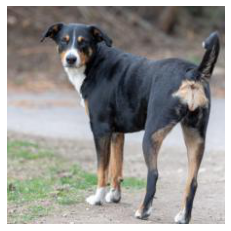

In [9]:
labels = load_labels('imagenet-simple-labels.json')
image = Image.open('images/cute-4074304_224.jpg')

print("Image size: ", image.size)
plt.axis('off')
display_image = plt.imshow(image)

In [10]:
start = time.time()
image_data = np.array(image).transpose(2, 0, 1)
input_data = preprocess(image_data)
raw_result = session.run([], {input_name: input_data})
end = time.time()

Final top prediction is: Appenzeller Sennenhund
============ Top 5 labels are: ============================
['Appenzeller Sennenhund' 'Entlebucher Sennenhund' 'Australian Kelpie'
 'Greater Swiss Mountain Dog' 'Border Collie']
Inference time: 19.49 ms


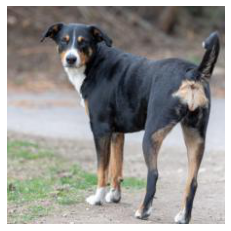

In [11]:
def predict(raw_result):
    res = postprocess(raw_result)
    
    idx = np.argmax(res)

    print('========================================')
    print('Final top prediction is: ' + labels[idx])
    print('========================================')

    sort_idx = np.flip(np.squeeze(np.argsort(res)))
    print('============ Top 5 labels are: ============================')
    print(labels[sort_idx[:5]])
    print('===========================================================')

    plt.axis('off')
    display_image = plt.imshow(image)

def display_time(start, end):
    inference_time = np.round((end - start) * 1000, 2)
    print('========================================')
    print('Inference time: ' + str(inference_time) + " ms")
    print('========================================')

predict(raw_result)
display_time(start, end)

### Creating an ONNX graph for preprocessing

As a proof-of-concept, we will create another ONNX model, representing the data preprocessing pipeline for a single sample. The preprocessing model is then saved to a file for later use.

In [12]:
import onnx.helper as h
import onnx.checker as checker
from onnx import version_converter
from onnx import save
from onnx import TensorProto as tp

op = onnx.OperatorSetIdProto()
op.version = 14

# Creating a preprocessing graph

# Convert to float
# Converting image data from uint8 to float
cast_n = h.make_node(
    'Cast', inputs=['x'], outputs=['xf'], name='cast-node', to=tp.FLOAT
)

# Normalization
# Mean constant
mean_k = h.make_node(
    'Constant', inputs=[], outputs=['mean_k'], name="mean_k-node", 
    value=h.make_tensor(name="mean_k-v", data_type=tp.FLOAT, 
    dims=[3], vals=[255*0.485, 255*0.456, 255*0.406])
)
# Stddev constant
stddev_k = h.make_node(
    'Constant', inputs=[], outputs=['stddev_k'], name="stddev_k-node", 
    value=h.make_tensor(name="stddev_k-v", data_type=tp.FLOAT, 
    dims=[3], vals=[255*0.229, 255*0.224, 255*0.225])
)
# Subtract mean
sub_n = h.make_node('Sub', inputs=['xf', 'mean_k'], outputs=['xf_1'], name='sub-node')
# Divide by standard deviation
div_n = h.make_node('Div', inputs=['xf_1', 'stddev_k'], outputs=['x_norm'], name="div-node")

# Transpose
# From HWC to CHW layout
tx_n = h.make_node('Transpose', inputs=['x_norm'], perm=[2, 0, 1], outputs=['xnorm_chw'], name='transpose-node')

# Unsqueeze (batch dimension)
# From CHW to NCHW
unsqueeze_axes_k = h.make_node(
    'Constant', inputs=[], outputs=['unsqueeze_axes_k'], name="unsqueeze_axes_k-node", 
    value=h.make_tensor(name="unsqueeze_axes_k-v", data_type=tp.INT64, 
    dims=[1], vals=[0])
)

unsqueeze_n = h.make_node('Unsqueeze', inputs=['xnorm_chw', 'unsqueeze_axes_k'], 
                          outputs=['xnorm_nchw'], name='unsqueeze-node')

# Create the graph
g = h.make_graph(
    [cast_n, mean_k, stddev_k, sub_n, div_n, tx_n, unsqueeze_axes_k, unsqueeze_n], 'rn50-data-pipe',
    [h.make_tensor_value_info('x', tp.UINT8, [-1, -1, -1])],
    [h.make_tensor_value_info('xnorm_nchw', tp.FLOAT, [1, -1, -1, -1])]
)

# Make the preprocessing model
m = h.make_model(g, producer_name='onnx-preprocessing-demo', opset_imports=[op])
checker.check_model(m)

# Save the model to a file
save(m, 'rn50-preprocessing.onnx')

### Testing the preprocessing model
Let us check the data preprocessing model by running it on an image sample.

Image size:  (224, 224)
Preprocessed size:  (1, 3, 224, 224)


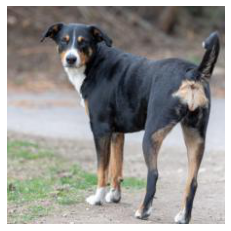

In [13]:
image = Image.open('images/cute-4074304_224.jpg')
print("Image size: ", image.size)
plt.axis('off')
display_image = plt.imshow(image)

# Run the model on the backend
preprocessing_session = onnxruntime.InferenceSession('rn50-preprocessing.onnx', None)

# get the name of the first input of the model
input_name = preprocessing_session.get_inputs()[0].name  
raw_result = preprocessing_session.run([], {input_name: np.array(image)})

print("Preprocessed size: ", raw_result[0].shape)

### Classify sample images, using an ONNX model for preprocessing
We are now ready to replace the preprocessing step with the the preprocessing ONNX model we just created.

Final top prediction is: Appenzeller Sennenhund
============ Top 5 labels are: ============================
['Appenzeller Sennenhund' 'Entlebucher Sennenhund' 'Australian Kelpie'
 'Greater Swiss Mountain Dog' 'Border Collie']
Inference time: 35.88 ms


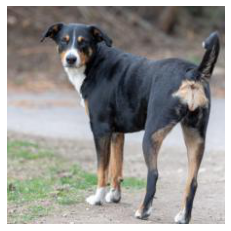

In [14]:
start = time.time()
preprocessed = preprocessing_session.run([], {'x': np.array(image)})[0]
raw_result = session.run([], {'data': preprocessed})
end = time.time()

predict(raw_result)
display_time(start, end)

### Adding resize and crop to the pipeline

So far we tested images that were already of the expected size (224 x 224). To support any image, the preprocessing pipeline should include image resizing and cropping.

In [15]:
from PIL import Image

def preprocess(image):
    # resize so that the shorter side is 256, maintaining aspect ratio
    def image_resize(image, min_len):
        image = Image.fromarray(image)
        ratio = float(min_len) / min(image.size[0], image.size[1])
        if image.size[0] > image.size[1]:
            new_size = (int(round(ratio * image.size[0])), min_len)
        else:
            new_size = (min_len, int(round(ratio * image.size[1])))
        image = image.resize(new_size, Image.BILINEAR)
        return np.array(image)
    image = image_resize(image, 256)

    # Crop centered window 224x224
    def crop_center(image, crop_w, crop_h):
        h, w, c = image.shape
        start_x = w//2 - crop_w//2
        start_y = h//2 - crop_h//2    
        return image[start_y:start_y+crop_h, start_x:start_x+crop_w, :]
    image = crop_center(image, 224, 224)
    
    # transpose
    image = image.transpose(2, 0, 1)

    # convert the input data into the float32 input
    img_data = image.astype('float32')    
    
    # normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]
    
    # add batch channel
    norm_img_data = norm_img_data.reshape(1, 3, 224, 224).astype('float32')
    return norm_img_data

Final top prediction is: snail
============ Top 5 labels are: ============================
['snail' 'slug' 'conch' 'electric ray' 'terrapin']
Inference time: 52.43 ms


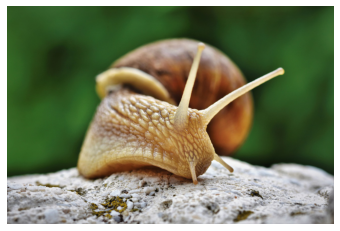

In [16]:
image = Image.open('images/snail-4345504_1280.jpg')

start = time.time()
input_data = preprocess(np.array(image))
raw_result = session.run([], {'data': input_data})
end = time.time()

predict(raw_result)
display_time(start, end)

Now we can add the Resize and Crop steps to the ONNX preprocessing graph as well.

Resize operator expects explicit new shapes of scale factors for all dimensions. In RN50, we resize to a shape not smaller than 256x256 keeping aspect ratio. That means that the shorter dimension is resized to at least 256 and the other dimension is scaled accordingly to keep the aspect ratio. To achieve that with current operator set, some shape processing is required.

$$
  scales_{x, y} = \frac{256}{\min{H, W}}, \ scales_{z} = 1
$$

Similarly, some shape processing is required to produce a 224x224 centered cropping window.

$$
  start = \Bigg[ \frac{H - 224}{2}, \frac{W - 224}{2}\ \Bigg], \ end = start + 224
$$

Let us rewrite the preprocessing model:

In [17]:
import onnx.helper as h
import onnx.checker as checker
from onnx import save
from onnx import TensorProto as tp

# Creating a preprocessing graph

# Resize to at least 256x256, keeping aspect ratio

def build_rn50_preprocessing_model(model_file, batchify=True):
    nodes = []

    nodes.append(
        h.make_node('Shape', inputs=['x'], outputs=['x_shape'], name='x_shape')
    )

    nodes.append(
        h.make_node('Split', inputs=['x_shape'], outputs=['h', 'w', 'c'], axis=0, name='split_shape')
    )

    nodes.append(
        h.make_node('Min', inputs=['h', 'w'], outputs=['min_extent'], name='min_extent')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_256'], 
                    value=h.make_tensor(name='k256', data_type=tp.FLOAT, dims=[1], vals=[256.0]), 
                    name='constant_256')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_1'], 
                    value=h.make_tensor(name='k1', data_type=tp.FLOAT, dims=[1], vals=[1.0]),
                   name='constant_1')
    )

    nodes.append(
        h.make_node('Cast', inputs=['min_extent'], outputs=['min_extent_f'], to=tp.FLOAT, name='min_extent_f')
    )

    nodes.append(
        h.make_node('Div', inputs=['constant_256', 'min_extent_f'], outputs=['ratio-resize'], name='ratio-resize')
    )

    nodes.append(
        h.make_node('Concat', inputs=['ratio-resize', 'ratio-resize', 'constant_1'], outputs=['scales-resize'],
                    axis=0, name='scales-resize')
    )        

    nodes.append(
        h.make_node('Resize', inputs=['x', '', 'scales-resize'], outputs=['x_resized'], mode='linear', name='x_resize')
    )

    # Centered crop 224x224
    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_224'], 
                    value=h.make_tensor(name='k224', data_type=tp.INT64, dims=[1], vals=[224]), name='constant_224')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_2'], 
                    value=h.make_tensor(name='k2', data_type=tp.INT64, dims=[1], vals=[2]), name='constant_2')
    )

    nodes.append(
        h.make_node('Shape', inputs=['x_resized'], outputs=['x_shape_2'], name='x_shape_2')
    )

    nodes.append(
        h.make_node('Split', inputs=['x_shape_2'], outputs=['h2', 'w2', 'c2'], name='split_shape_2')
    )

    nodes.append(
        h.make_node('Concat', inputs=['h2', 'w2'], outputs=['hw'], axis=0, name='concat_2')
    )   

    nodes.append(
        h.make_node('Sub', inputs=['hw', 'constant_224'], outputs=['hw_diff'], name='sub_224')
    )

    nodes.append(
        h.make_node('Div', inputs=['hw_diff', 'constant_2'], outputs=['start_xy'], name='div_2')
    )

    nodes.append(
        h.make_node('Add', inputs=['start_xy', 'constant_224'], outputs=['end_xy'], name='add_224')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['axes'], 
                    value=h.make_tensor(name='axes_k', data_type=tp.INT64, dims=[2], vals=[0, 1]), name='axes_k')
    )

    nodes.append(
        h.make_node('Slice', inputs=['x_resized', 'start_xy', 'end_xy', 'axes'], outputs=['x_cropped'], name='x_crop')
    )

    # Convert to float
    # Converting image data from uint8 to float
    nodes.append(
        h.make_node('Cast', inputs=['x_cropped'], outputs=['xf'], to=tp.FLOAT, name='cast_f')
    )

    # Normalization

    # Mean constant
    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['mean_k'], 
                    value=h.make_tensor(name="mean_k-v", data_type=tp.FLOAT, 
                                        dims=[3], vals=[255*0.485, 255*0.456, 255*0.406]), name='meak_k')
    )

    # Stddev constant
    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['stddev_k'], 
                    value=h.make_tensor(name="stddev_k-v", data_type=tp.FLOAT, 
                                        dims=[3], vals=[255*0.229, 255*0.224, 255*0.225]), name='stddev_k')
    )

    # Subtract mean
    nodes.append(
        h.make_node('Sub', inputs=['xf', 'mean_k'], outputs=['xf_1'], name='sub_mean')
    )

    # Divide by standard deviation
    nodes.append(
        h.make_node('Div', inputs=['xf_1', 'stddev_k'], outputs=['x_norm'], name='div_stddev')
    )

    # Transpose

    # From HWC to CHW layout
    nodes.append(
        h.make_node('Transpose', inputs=['x_norm'], perm=[2, 0, 1], outputs=['xnorm_chw'], name='transpose_chw')
    )

    if batchify:
        # Unsqueeze (batch dimension)

        # From CHW to NCHW
        nodes.append(
            h.make_node('Constant', inputs=[], outputs=['unsqueeze_axes_k'], 
                        value=h.make_tensor(name="unsqueeze_axes_k-v", data_type=tp.INT64, 
                                            dims=[1], vals=[0]), name='unsqueeze_axes_k')
        )

        nodes.append(
            h.make_node('Unsqueeze', inputs=['xnorm_chw', 'unsqueeze_axes_k'], outputs=['xnorm_nchw'], name='unsqueeze')
        )

        # Create the graph
        g = h.make_graph(nodes, 'rn50-data-pipe-resize',
            [h.make_tensor_value_info('x', tp.UINT8, [-1, -1, -1])],
            [h.make_tensor_value_info('xnorm_nchw', tp.FLOAT, [1, -1, -1, -1])]
        )
    else:
        # Create the graph
        g = h.make_graph(nodes, 'rn50-data-pipe-resize',
            [h.make_tensor_value_info('x', tp.UINT8, [-1, -1, -1])],
            [h.make_tensor_value_info('xnorm_chw', tp.FLOAT, [-1, -1, -1])]
        )


    # Make the preprocessing model
    m = h.make_model(g, producer_name='onnx-preprocessing-resize-demo', opset_imports=[op])
    checker.check_model(m)

    # Save the model to a file
    save(m, model_file)

MODEL_FILE = 'rn50-preprocessing-resize.onnx'
build_rn50_preprocessing_model(MODEL_FILE)
preprocessing_session2 = onnxruntime.InferenceSession(MODEL_FILE, None)

And finally, verify that it still behaves as expected

Final top prediction is: snail
============ Top 5 labels are: ============================
['snail' 'slug' 'conch' 'chambered nautilus' 'electric ray']
Inference time: 42.87 ms


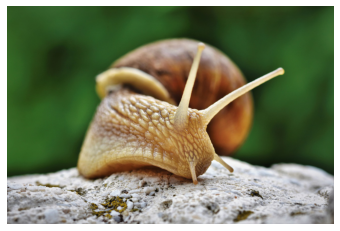

In [18]:
start = time.time()
preprocessed = preprocessing_session2.run([], {'x': np.array(image)})[0]
raw_result = session.run([], {'data': preprocessed})
end = time.time()

predict(raw_result)
display_time(start, end)

### Comparing the preprocessing results

If we compare the results of both approaches, we can see how the error is small (we need to scale the absolute difference significantly to be able to see it) but noticeable. 

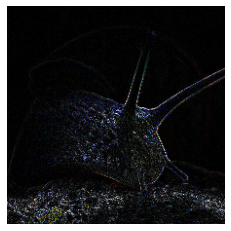

In [19]:
data_numpy = preprocess(np.array(image)).squeeze(0).transpose(1, 2, 0)
data_onnx = preprocessing_session2.run([], {'x': np.array(image)})[0].squeeze(0).transpose(1, 2, 0)

abs_diff = (np.abs(data_numpy - data_onnx) * 255).astype('uint8')
diff_img = Image.fromarray(abs_diff)
plt.axis('off')
i1 = plt.imshow(diff_img)

### Removing explicit batchification from the model

So far, we introduced an Unsqueeze node in the preprocessing model, so that the input to the network has a leading batch dimension. This works for the single example, but it'd be more convenient to be able to define the preprocessing pipeline in terms of a single sample, and leave batch formation to the tools.

Let us generate another preprocessing model, this time without the Unsqueeze node

In [20]:
# Saving the same model, without the Unsqueeze node,
# so that we can test the merging utils we are about to introduce
MODEL_PREPROCESSING_SAMPLE = 'rn50-preprocessing-sample.onnx'
build_rn50_preprocessing_model(MODEL_PREPROCESSING_SAMPLE, batchify=False)

## Merging models

Another idea, is to still distribute the two models separately, but combine them to a single model before running. We can achieve that by using the compose tools introduced by [this PR](https://github.com/jantonguirao/onnx/commits/compose_tools).

The first step is to modify both models so that the outputs an inputs names for each of the nodes do not collide. The second step is to add a leading batch dimension to the output of the preprocessing graph, since it is defined of a per-sample basis.
The final step is to merge both models, by connecting the outputs of the preprocessing model to the inputs of the main model.

In [21]:
preprocessing_model = onnx.load(MODEL_PREPROCESSING_SAMPLE)
checker.check_model(preprocessing_model)

# Load the network and remove deprecated arguments from BatchNormalization so that it can be saved as
# opset=14
MODEL_NETWORK = 'resnet50v2/resnet50v2.onnx'

# The original model contains BatchNormalization nodes including a deprecated
# argument `spatial`. In this function we remove that argument from each of the nodes
def model_surgery(model):
    for n in model.graph.node:
        if n.op_type == "BatchNormalization":
            for attribute in n.attribute:
                if attribute.name == 'spatial':
                    n.attribute.pop()
    return model

network_model = onnx.load(MODEL_NETWORK)
network_model = model_surgery(network_model)
checker.check_model(network_model)

g_pre = preprocessing_model.graph
g_model = network_model.graph

# Inserts unsqueeze at the end of the preprocessing graph, 
# the combined model will take a single sample as an input.
g_pre = onnx.compose.expand_out_dim(g_pre, 0)

# Adds prefix so that names don't collide
g_pre = onnx.compose.add_prefix(g_pre, 'preprocessing/')

# Combine two graphs into a single one. Specific pairs of output->input are specified
g_combined = onnx.compose.merge(g_pre, g_model, io_map=[("preprocessing/xnorm_chw_expanded", "data")])

# Now we are ready to create the model, check it and save it
combined_model = onnx.helper.make_model(g_combined, 
                                        opset_imports=[op],
                                        producer_name=network_model.producer_name,
                                        ir_version=network_model.ir_version)

MODEL_W_PREPROCESSING = 'rn50-with-preprocessing.onnx'
checker.check_model(combined_model)
save(combined_model, MODEL_W_PREPROCESSING)

Final top prediction is: snail
============ Top 5 labels are: ============================
['snail' 'slug' 'conch' 'chambered nautilus' 'electric ray']
Inference time: 30.6 ms


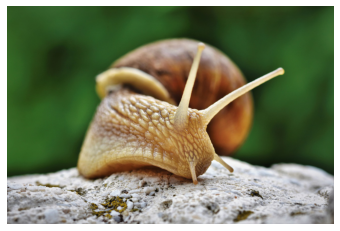

In [22]:
# Running an inference session on the combined model
session_w_preprocessing = onnxruntime.InferenceSession(MODEL_W_PREPROCESSING, None)

start = time.time()
raw_result = session_w_preprocessing.run([], {'preprocessing/x': np.array(image)})
end = time.time()

predict(raw_result)
display_time(start, end)